Imports necessary libraries for data analysis, preprocessing, modeling, and visualization.

Creates an output directory named 'output' if it doesn't exist. This will be used to store output files or visualizations generated later in the code.

In [1]:
!pip install -U -q fcapy[all]==0.1.4


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from fcapy.lattice import ConceptLattice
from fcapy.context import FormalContext
import os 

    
output_dir = 'output'
os.makedirs(output_dir, exist_ok=True)
 

<span style="font-size: 0.75em;">

# Financial Literacy Data Processing

This script processes and cleans datasets from two different years (2017 and 2020) related to financial literacy. The final output is a prepared DataFrame ready for further analysis or modeling. Below is a step-by-step explanation of the process:

## 1. Load Datasets and Compare Columns
The script begins by loading two datasets, one from 2017 and the other from 2020. It then compares the columns of these datasets:
- If the columns match, a message `"PASS_20_17"` is printed.
- If the columns do not match, the differences are identified and displayed.

## 2. Merge DataFrames and Initial Cleaning
Next, the two datasets are merged into a single DataFrame. Some initial data cleaning is performed:
- A new column `key` is added as a unique identifier, which is then set as the index of the DataFrame.
- The redundant `id` column is dropped.

## 3. Preprocess `qprod1_d`, `qprod2`, `qk4`, `qk5`, and `qf10_*` Variables
Certain variables require specific preprocessing:
- Missing values in specific columns (`qprod1_d` and `qprod2`) are filled with predefined values (`99` and `-99`, respectively).
- The variables `qk4` and `qk5` are recoded, grouping the answers of variables qk4 and qk5, imposing 1 on all incorrect answers.
- Variables that start with `qf10_` have invalid values (`-97`, `-99`) replaced with the mode (most frequent value) of each column to get an integer variable.

## 4. Define and Encode Variables
The script then categorizes the variables into three types:
- **Binary variables**: Variables with binary (0/1) responses.
- **Integer variables**: Variables with integer responses, including the `qf10_*` variables.
- **Continuous variables**: Variables with continuous numeric responses (e.g., `pesofitc`).

The remaining columns are treated as **categorical variables**. These categorical variables are encoded using `OneHotEncoder`, which converts them into binary (0/1) features.

## 5. Create and Finalize the Final DataFrame
The final DataFrame (`db_final`) is created by combining the binary, integer, and encoded categorical variables. Any remaining missing values are filled with `0`.

## 6. Check for Missing Values
Lastly, the script checks if there are any remaining missing values in the final DataFrame:
- If missing values are detected, a warning message is printed.
- If there are no missing values, a success message is displayed.

This structured approach ensures that the data is clean, consistent, and ready for any further analysis or machine learning tasks.

In [66]:
# 1. Load Datasets and Compare Columns
df_2017 = pd.read_csv("data/Financia_literacy_2017.csv")
df_2020 = pd.read_csv("data/Financia_literacy_2020.csv")

geodemo = ["AREA5","qd10", "qd9"]

if (df_2020.columns == df_2017.columns).all():
    print("PASS_20_17")
else:
    print("FAIL_20_17")
    print("df_20: YES , df_17: NO", set(df_2020.columns) - set(df_2017.columns))
    print("df_17: YES , df_20: NO", set(df_2017.columns) - set(df_2020.columns))

# 2. Merge DataFrames and creates a new index
db = pd.concat([df_2017, df_2020], axis=0, ignore_index=True)
db['key'] = range(len(db))
db.set_index('key', inplace=True)
db.drop(columns=["id"], inplace=True)

# 3. Preprocess qprod1_d, qprod2, qk4, qk5, and qf10_* Variables
db.fillna({"qprod1_d": 99, "qprod2": -99}, inplace=True)

db['qk4'] = np.where(db['qk4'].isin([-97, -99, 0]), db['qk4'], 1)
db['qk5'] = np.where(db['qk5'].isin([-97, -99, 102]), db['qk5'], 1)

qf10_cols = [col for col in db.columns if col.startswith("qf10_")]
for col in qf10_cols:
    mode_value = db[col].mode()[0]
    db[col] = db[col].replace([-97, -99], mode_value)

# 4. Define Variables Type and Encode Variables Categorical ones
binary_variables = [
    "qd1", "SM", "qd12", "qprod1c_1", "qprod1c_2", "qprod1c_3", "qprod1c_5", "qprod1c_6", "qprod1c_7",
    "qprod1c_8", "qprod1c_10", "qprod1c_11", "qprod1c_12", "qprod1c_14", "qprod1c_99", "qf3_1", "qf3_3", "qf3_4",
    "qf3_6", "qf3_7", "qf3_8", "qf3_99", "qf9_1", "qf9_10", "qf9_2", "qf9_3", "qf9_4", "qf9_5", "qf9_6", "qf9_7",
    "qf9_8", "qf9_9", "qf9_99", "qprod3_1", "qprod3_2", "qprod3_3", "qprod3_4", "qprod3_5", "qprod3_6", "qprod3_7",
    "qprod3_8", "qprod3_9", "qprod3_10", "qprod3_11", "qprod3_12", "qprod3_13", "qprod3_14", "qprod3_15", "qprod3_16",
    "qprod3_17", "qprod3_18", "qprod3_99", "qf12_1_a", "qf12_1_b", "qf12_1_c", "qf12_2_d", "qf12_3_e", "qf12_3_f",
    "qf12_3_g", "qf12_4_k", "qf12_4_l", "qf12_5_m", "qf12_5_o", "qf12_6_p", "qf12_6_q", "qf12_7_r", "qf12_97", "qf12_99"
]
integer_variables = ["qd5b", "qd7"] + qf10_cols
continuous_variables = ["pesofitc"]

categorical_variables = db.columns.difference(binary_variables + integer_variables + continuous_variables)

encoder = OneHotEncoder(drop='first')
encoded_cols = encoder.fit_transform(db[categorical_variables])
encoded_df = pd.DataFrame(encoded_cols.toarray(), columns=encoder.get_feature_names_out(categorical_variables))

# 5. Create and Finalize the Final DataFrame
db_final = pd.concat([db[binary_variables + integer_variables + geodemo], encoded_df], axis=1).fillna(0)

# 6. Check for Missing Values
if db_final.isna().any().any():
    print("Missing values exist.")
else:
    print("No missing values.")

PASS_20_17
No missing values.


In [73]:
# Definizione delle generazioni basate sull'anno di nascita
def categorize_generation(age):
    if age >= 80:  # Nati prima del 1945
        return "Silent_Generation"
    elif 64 <= age <= 79:  # Nati tra 1945 e 1960
        return "Boomers"
    elif 50 <= age <= 63:  # Nati tra 1961 e 1974
        return "Gen_X"
    elif 34 <= age <= 49:  # Nati tra 1975 e 1990
        return "Millennials"
    elif 18 <= age <= 33:  # Nati tra 1991 e 2006
        return "Gen_Z"
    else:
        return "Unknown"

# Creazione della nuova colonna con la generazione
db_final["generation"] = db_final["qd7"].apply(categorize_generation)

<span style="font-size: 1em;">

### Variable Selection for Financial Literacy Analysis

In this analysis, I have specifically defined and selected variables based on the questions from the questionnaire that are directly used to calculate the financial literacy scores.
\\
These variables are categorized into three key components: **knowledge**, **behavior**, and **attitude**. 

In [6]:
knowledge_answer = ["qk3_2","qk3_3","qk3_-97","qk3_1", #qk3
                       "qk4_1","qk4_-97","qk4_0", #qk4
                       "qk5_1","qk5_-97","qk5_102", #qk5
                       "qk6_2","qk6_3","qk6_4","qk6_-97","qk6_1", #qk6
                       "qk7_1_0","qk7_1_-97","qk7_1_1", #qk7_1
                       "qk7_2_0","qk7_2_-97","qk7_2_1", #qk7_2
                       "qk7_3_0","qk7_3_-97","qk7_3_1",] #qk7_3

behevioral_answer =  ["qf1_2","qf1_3","qf1_1", #qf1
                        "qf2_0","qf2_1", #qf2
                        "qf3_1","qf3_3","qf3_4","qf3_6","qf3_7","qf3_8","qf3_99", #qf3
                        "qf10_1", #qf10_1
                        "qf10_4", #qf10_4
                        "qf10_6", #qf10_6
                        "qf10_7", #qf10_7
                        "qprod2_2.0","qprod2_3.0","qprod2_4.0","qprod2_1.0", #qprod2
                        "qprod3_1","qprod3_2","qprod3_3","qprod3_4","qprod3_5","qprod3_6","qprod3_7","qprod3_8","qprod3_9","qprod3_10","qprod3_11","qprod3_12","qprod3_13","qprod3_14","qprod3_15","qprod3_16","qprod3_17","qprod3_18","qprod3_99", #qprod3
                        "qf12_1_a","qf12_1_b","qf12_1_c","qf12_2_d","qf12_3_e","qf12_3_f","qf12_3_g","qf12_4_k","qf12_4_l","qf12_5_m","qf12_5_o","qf12_6_p","qf12_6_q","qf12_7_r","qf12_97","qf12_99" #qf12
                        ]

attitude_answer = ["qf10_2","qf10_3","qf10_8"] #qf10


## 🔹 Punteggi di conoscenza (Knowledge Score)
Vengono creati punteggi binari per le variabili `qk3` - `qk7`, assegnando il valore **1** se la risposta corrisponde a `1` e **0** altrimenti.

## 🔹 Punteggi comportamentali (Behavioral Score)
- **`qf1_qf2_score`**: Assegna **1** se almeno una delle due variabili `qf1_1` o `qf1_2` è `1` e contemporaneamente `qf2_1` è `1`.  
- **`qf3_score`**: Assegna **1** se almeno una delle variabili `qf3_1`, `qf3_4`, `qf3_6`, `qf3_7` o `qf3_8` è `1`.  
- **`qf10_1_score`**, **`qf10_4_score`**, **`qf10_6_score`**, **`qf10_7_score`**: Assegna **1** se il valore è `1` o `2`.

## 🔹 Variabili di produzione
- **`temp_qprod2`**: Assegna **1** se almeno una delle variabili `qprod2_1.0` o `qprod2_4.0` è `1`.  
- **`temp_qprod3`**: Calcola un valore tra 0 e 2 in base a specifiche condizioni:  
  - Se almeno una delle variabili `qprod3_5` - `qprod3_8` è `1`, assegna **2**.  
  - Se almeno una delle variabili `qprod3_2`, `qprod3_3`, `qprod3_4`, ecc. è `1`, assegna **1**.  
- **`qprod_2pt_score`**: Assegna **1** se `temp_qprod3` è esattamente `2`.  
- **`qprod_1pt_score`**: Assegna **1** se `temp_qprod2` o `temp_qprod3` è almeno `1`.  

## 🔹 Punteggio di credito (Credit Score)
- **`qf12_score`**: Se un individuo ha usato almeno un'opzione di credito (valore diverso da 0 in `credit_columns`), assegna **0**. Se non ha usato il credito, assegna **1**.

## 🔹 Punteggi di atteggiamento (Attitude Score)
- **`qf10_2_score`**, **`qf10_3_score`**, **`qf10_8_score`**: Assegna **1** se il valore è **4 o 5**, altrimenti **0**.

Questo codice permette di trasformare le risposte di un questionario in variabili binarie che possono essere usate per analisi statistiche o modelli di machine learning. 🚀


In [76]:
import pandas as pd

# Creazione dei punteggi di conoscenza (Knowledge Score)
db_final["qk3_score"] = (db_final["qk3_3"] == 1).astype(int)
db_final["qk4_score"] = (db_final["qk4_0"] == 1).astype(int)
db_final["qk5_score"] = (db_final["qk5_102"] == 1).astype(int)
db_final["qk6_score"] = (db_final["qk6_1"] == 1).astype(int)
db_final["qk7_1_score"] = (db_final["qk7_1_1"] == 1).astype(int)
db_final["qk7_2_score"] = (db_final["qk7_2_1"] == 1).astype(int)
db_final["qk7_3_score"] = (db_final["qk7_3_1"] == 1).astype(int)

# Creazione dei punteggi comportamentali (Behavioral Score)
db_final["qf1_qf2_score"] = (((db_final["qf1_1"] == 1) | (db_final["qf1_2"] == 1)) & (db_final["qf2_1"] == 1)).astype(int)
db_final["qf3_score"] = db_final[["qf3_1", "qf3_4", "qf3_6", "qf3_7", "qf3_8"]].sum(axis=1).gt(0).astype(int)
db_final["qf10_1_score"] = db_final["qf10_1"].isin([1, 2]).astype(int)
db_final["qf10_4_score"] = db_final["qf10_4"].isin([1, 2]).astype(int)
db_final["qf10_6_score"] = db_final["qf10_6"].isin([1, 2]).astype(int)
db_final["qf10_7_score"] = db_final["qf10_7"].isin([1, 2]).astype(int)

# Creazione delle variabili temporanee per la produzione
db_final["temp_qprod2"] = db_final[["qprod2_1.0", "qprod2_4.0"]].sum(axis=1).gt(0).astype(int)

db_final["temp_qprod3"] = (
    (db_final[["qprod3_5", "qprod3_6", "qprod3_7", "qprod3_8"]].sum(axis=1) > 0).astype(int) * 2 +
    (db_final[["qprod3_2", "qprod3_3", "qprod3_4", "qprod3_9", "qprod3_10", "qprod3_11", "qprod3_12", "qprod3_13", "qprod3_18"]].sum(axis=1) > 0).astype(int)
)

db_final["qprod_2pt_score"] = (db_final["temp_qprod3"] == 2).astype(int)
db_final["qprod_1pt_score"] = ((db_final["temp_qprod2"] == 1) | (db_final["temp_qprod3"] == 1)).astype(int)

credit_columns = ["qf12_3_e", "qf12_3_f", "qf12_3_g", "qf12_4_k", "qf12_4_l", "qf12_5_m",
                  "qf12_5_o", "qf12_6_p", "qf12_6_q"]

db_final["qf12_score"] = (db_final[credit_columns].sum(axis=1) == 0).astype(int)

# Creazione del punteggio di atteggiamento (Attitude Score)
db_final["qf10_2_score"] = db_final["qf10_2"].isin([4, 5]).astype(int)
db_final["qf10_3_score"] = db_final["qf10_3"].isin([4, 5]).astype(int)
db_final["qf10_8_score"] = db_final["qf10_8"].isin([4, 5]).astype(int)


In [81]:
knowledge_score_variables = [
    "qk3_score", "qk4_score", "qk5_score", "qk6_score", 
    "qk7_1_score", "qk7_2_score", "qk7_3_score"
]

# Behavioral Score
behavioral_score_variables = [
    "qf1_qf2_score", "qf3_score", "qf10_1_score", 
    "qf10_4_score", "qf10_6_score", "qf10_7_score",
    "qprod_2pt_score", "qprod_1pt_score", "qf12_score"
]

# Attitude Score
attitude_score_variables = [
    "qf10_2_score", "qf10_3_score", "qf10_8_score"
]

variabili_fca = knowledge_score_variables + behavioral_score_variables + attitude_score_variables

geodemo = ["qd1", "AREA5", "qd5b", "generation", "qd10", "qd9", "qd12"]

In [101]:
db_analysis = db_final[geodemo + knowledge_score_variables + behavioral_score_variables + attitude_score_variables]

In [102]:
db_analysis["total_score"] = db_final[variabili_fca].sum(axis=1)

C:\Users\lore9\AppData\Local\Temp\ipykernel_17412\1713651054.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  db_analysis["total_score"] = db_final[variabili_fca].sum(axis=1)


Principali caratteristiche della distribuzione:
count    4752.000000
mean        9.397727
std         2.899796
min         1.000000
25%         7.000000
50%         9.000000
75%        11.000000
max        18.000000
Name: total_score, dtype: float64


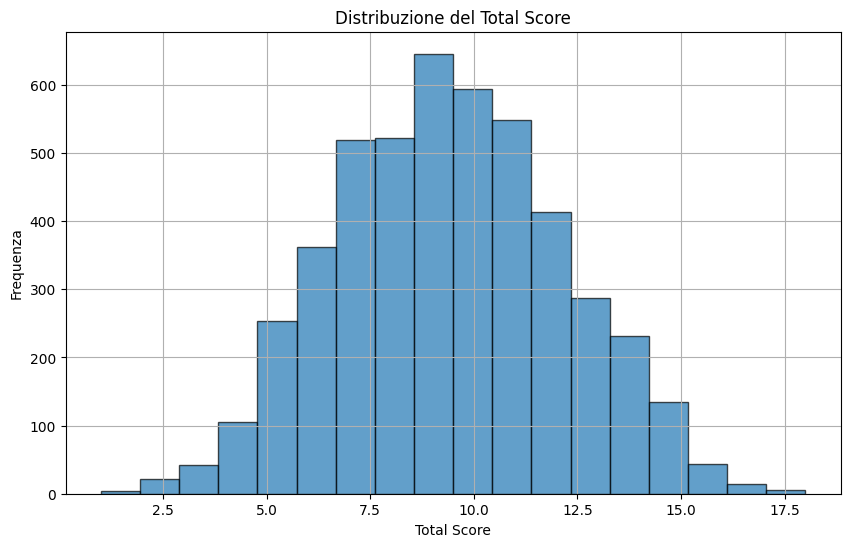

In [103]:
import matplotlib.pyplot as plt

# Calcolare le principali caratteristiche della distribuzione
distribution_stats = db_analysis["total_score"].describe()

# Stampare le statistiche principali
print("Principali caratteristiche della distribuzione:")
print(distribution_stats)

# Creare il grafico di distribuzione
plt.figure(figsize=(10, 6))
plt.hist(db_analysis["total_score"], bins=18, edgecolor='black', alpha=0.7)
plt.title("Distribuzione del Total Score")
plt.xlabel("Total Score")
plt.ylabel("Frequenza")
plt.grid(True)
plt.show()


In [111]:
# Seleziona le due variabili da usare per la segmentazione
var1 = "qd9"  # Sostituisci con il nome della prima variabile
var2 = "generation" 

# Creazione di una nuova variabile che è la concatenazione dei valori di var1 e var2
db_analysis["segmentation"] = db_analysis[var1].astype(str) + "_" + db_analysis[var2].astype(str) 

C:\Users\lore9\AppData\Local\Temp\ipykernel_17412\3881383780.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  db_analysis["segmentation"] = db_analysis[var1].astype(str) + "_" + db_analysis[var2].astype(str)


In [112]:
segmentation_score_mean = db_analysis.groupby("segmentation")["total_score"].mean()

In [116]:
db_analysis["segmentation"].value_counts()

segmentation
3_Millennials          674
3_Gen_X                524
4_Gen_X                430
1_Millennials          398
4_Millennials          374
4_Boomers              364
3_Gen_Z                344
1_Gen_Z                328
3_Boomers              278
5_Boomers              222
4_Gen_Z                206
1_Gen_X                196
1_Boomers              138
5_Silent_Generation     76
4_Silent_Generation     60
5_Gen_X                 34
6_Boomers               32
3_Silent_Generation     30
6_Silent_Generation     18
1_Silent_Generation     14
5_Millennials            8
5_Gen_Z                  2
7_Gen_Z                  2
Name: count, dtype: int64

In [115]:
segmentation_score_mean

segmentation
1_Boomers              10.637681
1_Gen_X                10.683673
1_Gen_Z                 9.396341
1_Millennials          10.170854
1_Silent_Generation    12.142857
3_Boomers              10.338129
3_Gen_X                 9.973282
3_Gen_Z                 8.767442
3_Millennials           9.548961
3_Silent_Generation    10.000000
4_Boomers               9.373626
4_Gen_X                 9.162791
4_Gen_Z                 7.932039
4_Millennials           8.459893
4_Silent_Generation     8.566667
5_Boomers               8.711712
5_Gen_X                 6.705882
5_Gen_Z                11.000000
5_Millennials           7.750000
5_Silent_Generation     8.842105
6_Boomers               7.500000
6_Silent_Generation     6.000000
7_Gen_Z                 7.000000
Name: total_score, dtype: float64